**Compound Scaling**

In the paper, the authors propose a compound scaling method that uses a compound coefficient of \phi to uniformly scale width, depth, and resolution in a principled way

They propose the following formula
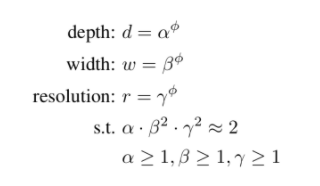

\phi is a user-specified coefficient that controls resources (e.g. Floating Point Operations (FLOPs)) available for model scaling.

\alpha, \beta, \gamma distribute the resources to depth, width, and resolution respectively.

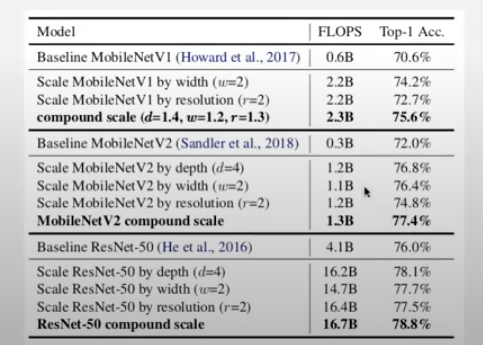

**Model Scaling EfficientNet-B0**

Starting with EfficientNet-B0, the authors used the following strategy to scale it up.

1. Fix \phi = 1.
2. Assume the resource available at any step of scaling is twice of the resource at the previous step.
3. Do a small grid search over \alpha, \beta, and \gamma such that the constraint in the above equation is not violated.
4. The authors found the parameters \alpha = 1.2, \beta = 1.1, \gamma = 1.15 to work the best.
5. Fix \alpha, \beta, and \gamma as constants and scale up EfficientNet-B0 with different \phi to obtain new scaled networks EfficientNet-B1 to B7.

**EfficientNet Performance**

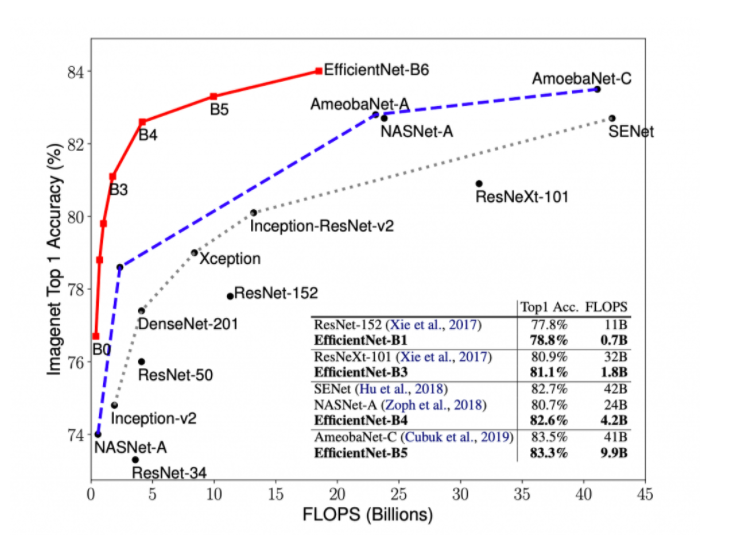

It shows that for the same FLOPS, the accuracy of EfficientNet than any existing architecture. So, if you were planning to use Inception-v2, you should consider using EfficientNet-B1 instead. Similarly, it is a good idea to consider EfficientNet-B2 if you were planning to use ResNet-50.

In [ ]:
!pip install -q efficientnet --quiet

In [ ]:
#Imports
import math, re, os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import load_model
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


In [ ]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 10 # original 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [ ]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [ ]:
sub = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')
train_filenames = np.array(os.listdir("/kaggle/input/alaska2-image-steganalysis/Cover/"))

In [ ]:
train_filenames

In [ ]:
np.random.seed(0)
positives = train_filenames.copy()
negatives = train_filenames.copy()
np.random.shuffle(positives)
np.random.shuffle(negatives)


jmipod = append_path('JMiPOD')(positives[:10000])
juniward = append_path('JUNIWARD')(positives[10000:20000])
uerd = append_path('UERD')(positives[20000:30000])

pos_paths = np.concatenate([jmipod, juniward, uerd])

In [ ]:
test_paths = append_path('Test')(sub.Id.values)
neg_paths = append_path('Cover')(negatives[:30000])

In [ ]:
train_paths = np.concatenate([pos_paths, neg_paths])
train_labels = np.array([1] * len(pos_paths) + [0] * len(neg_paths))

In [ ]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=2020)

In [ ]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

validTest_dataset = (
    tf.data.Dataset
    .from_tensor_slices(valid_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [ ]:
def build_lrfn(lr_start=0.00001, lr_max=0.00008, 
               lr_min=0.000001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

**Global Average Pooling**

When applying Global Average Pooling, the pool size is still set to the size of the layer input, but rather than the maximum, the average of the pool is taken:

Screenshot 2020-09-29 at 10.56.12 AM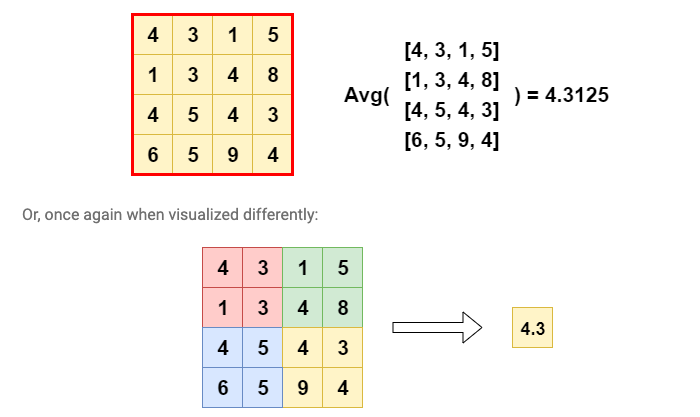


In [ ]:
with strategy.scope():
    # EfficientNetB7
    model = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(512, 512, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
        
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    
    # EfficientNetB3
    model2 = tf.keras.Sequential([
        efn.EfficientNetB3(
            input_shape=(512, 512, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
        
    model2.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )

**binary_crossentropy**

Binary crossentropy is a loss function that is used in binary classification tasks. These are tasks that answer a question with only two choices (yes or no, A or B, 0 or 1, left or right).

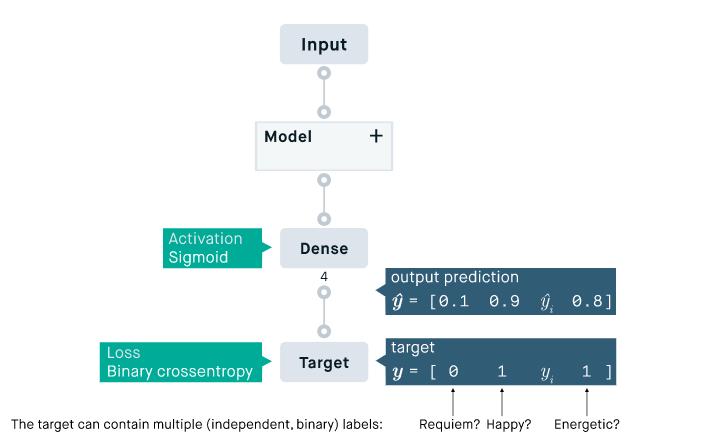

**Binary crossentropy math**

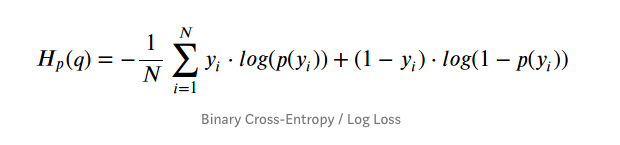
where y is the label (1 for green points and 0 for red points) and p(y) is the predicted probability of the point being green for all N points.

Reading this formula, it tells you that, for each green point (y=1), it adds log(p(y)) to the loss, that is, the log probability of it being green. Conversely, it adds log(1-p(y)), that is, the log probability of it being red, for each red point (y=0).

In [ ]:
model.summary()

In [ ]:
model2.summary()

In [ ]:
checkpoint1 = tf.keras.callbacks.ModelCheckpoint('model_effnetb7.h5', save_best_only=True, monitor='val_loss', mode='min')
checkpoint2 = tf.keras.callbacks.ModelCheckpoint('model_effnetb3.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')

In [ ]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

In [ ]:
history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[checkpoint1, reduce_lr_loss, lr_schedule],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset
)

In [ ]:
history2 = model2.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[checkpoint2, reduce_lr_loss, lr_schedule],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset
)

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy', 212)

In [ ]:
display_training_curves(
    history2.history['loss'], 
    history2.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history2.history['accuracy'], 
    history2.history['val_accuracy'], 
    'accuracy', 212)

In [ ]:
pred1 = model.predict(validTest_dataset, verbose=1) # EfficientNetB7
pred2 = model2.predict(validTest_dataset, verbose=1) # EfficientNetB3

In [ ]:
_, acc = model.evaluate(validTest_dataset,test_dataset)
_, acc1 = model2_final.evaluate(validTest_dataset,test_dataset)

In [ ]:
print("Test Accuracy: {}%".format(acc*100))
print("Test Accuracy1: {}%".format(acc1*100))

In [ ]:
for i in range (len(pred1)):
    if pred1[i] > 0.5:
        pred1[i] = 1
    else:
        pred1[i] = 0

In [ ]:
for i in range (len(pred2)):
    if pred2[i] > 0.5:
        pred2[i] = 1
    else:
        pred2[i] = 0

In [ ]:
pred1

In [ ]:
pred2

In [ ]:
valid_labels

In [ ]:
c = 0
for i in range (len(pred1)):
    if pred1[i] == valid_labels[i]:
        c += 1
print(c/len(pred1))

In [ ]:
c = 0
for i in range (len(pred2)):
    if pred2[i] == valid_labels[i]:
        c += 1
print(c/len(pred2))